In [19]:
%matplotlib inline

import xarray as xr
import intake
import util 
import pprint 
import dask
import gsw
import matplotlib.pyplot as plt
import numpy as np

# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import xesmf as xe

nm = 12

In [12]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [13]:
cat = col.search(experiment_id=['historical'],table_id=['Omon'],institution_id='NCAR', variable_id=['thetao','so'],
                 member_id='r1i1p1f1', grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
14596,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,so,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
14602,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN


In [14]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


<xarray.DataArray 'lev' (lev: 60)>
array([5.000000e+00, 1.500000e+01, 2.500000e+01, 3.500000e+01, 4.500000e+01,
       5.500000e+01, 6.500000e+01, 7.500000e+01, 8.500000e+01, 9.500000e+01,
       1.050000e+02, 1.150000e+02, 1.250000e+02, 1.350000e+02, 1.450000e+02,
       1.550000e+02, 1.650984e+02, 1.754790e+02, 1.862913e+02, 1.976603e+02,
       2.097114e+02, 2.225783e+02, 2.364088e+02, 2.513702e+02, 2.676542e+02,
       2.854837e+02, 3.051192e+02, 3.268680e+02, 3.510935e+02, 3.782276e+02,
       4.087846e+02, 4.433777e+02, 4.827367e+02, 5.277280e+02, 5.793729e+02,
       6.388626e+02, 7.075633e+02, 7.870025e+02, 8.788252e+02, 9.847059e+02,
       1.106204e+03, 1.244567e+03, 1.400497e+03, 1.573946e+03, 1.764003e+03,
       1.968944e+03, 2.186457e+03, 2.413972e+03, 2.649001e+03, 2.889385e+03,
       3.133405e+03, 3.379793e+03, 3.627670e+03, 3.876452e+03, 4.125768e+03,
       4.375392e+03, 4.625190e+03, 4.875083e+03, 5.125028e+03, 5.375000e+03])
Coordinates:
  * lev      (lev) float64 

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


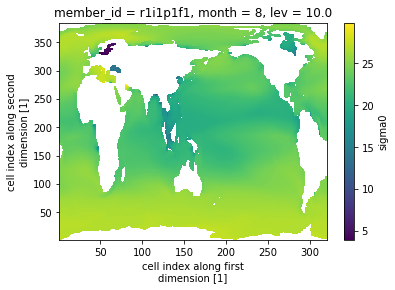

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


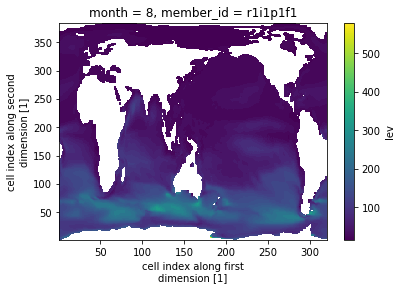

<xarray.DataArray 'relative_depth' (member_id: 1, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(1, 384, 320), dtype=float64, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    month      int64 8


In [15]:
# need to find index of depth or lev that is closest to 10m. If units are in centimeters, convert to meters

if 'depth' in dset_dict[i]:
    dset_dict[i].depth = xr.Dataset.rename({'depth':'lev'})
if dset_dict[i].lev.units == 'centimeters':
    dset_dict[i].lev.values = dset_dict[i].lev.values/100
    dset_dict[i].lev.attrs['units'] = 'm'
    
# big mamma loop-de-loop

for i in dset_dict:
    dset_dict[i]= dset_dict[i].sel(time=slice('1986','2005')).groupby('time.month').mean().sel(month=8)
    
    # calculate cthetao and add to ds
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, dset_dict[i].so, dset_dict[i].thetao, dask='parallelized',
                                         output_dtypes=[float,]).rename('cthetao').to_dataset()     
    dset_dict[i] = xr.merge([dset_dict[i],cthetao])
    
    # calculate sigma0 and add to ds
    sigma0 = xr.apply_ufunc(gsw.density.sigma0,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()                                                                          
    dset_dict[i] = xr.merge([dset_dict[i],sigma0])
    
    # calculate sigma2 and add to ds
    sigma2=xr.apply_ufunc(gsw.density.sigma2,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    dset_dict[i] = xr.merge([sigma2, dset_dict[i]])
    
    
    # interpolate density data
    dsi = dset_dict[i].sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    surf_dens.plot(); plt.show(); plt.close()
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = dset_dict[i].sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])    
    # plot for sanity check
    mld.plot(); plt.show(); plt.close()
        
    # get variables at bottom
    test = dset_dict[i].sigma0 + dset_dict[i].lev
    bottom_depth = dset_dict[i].lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_sigma2 = dset_dict[i].sigma2.where(test == test.max(['lev'])).max(dim='lev')
    bottom_temp = dset_dict[i].thetao.where(test == test.max(['lev'])).max(dim='lev')
    dset_dict[i]['bottom_depth'] = bottom_depth
    dset_dict[i]['bottom_sigma2'] = bottom_sigma2
    dset_dict[i]['bottom_temp'] = bottom_temp
    
    # ratio of mld to total depth
    dset_dict[i]['relative_depth'] = mld/bottom_depth
    print(dset_dict[i].relative_depth)
    

0


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Reuse existing file: bilinear_384x320_361x161_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: inva

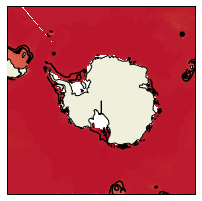

In [22]:
# Now let's try plotting:

# New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
# concentration for the contour plot (otherwise the contour will reverse on itself)
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + np.arange(1+(2*80)/res_new) # only go from 80S to 80N
lon_new = np.arange(1+(360)/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)

index = 0 # dummy index
fig = plt.figure(figsize=(20,20))
for i in dset_dict:
    print(index) # to make sure the calculation hasn't stalled
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the bottom potential density and find its size
    data = dset_dict[i].bottom_sigma2.squeeze()
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('bilinear')
    # Make method exceptions for models with weird grids around antarctica
#     if dset_dict[i].source_id == 'CNRM-CM6-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'CNRM-ESM2-1':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'EC-Earth3-Veg':
#         method = np.str('nearest_s2d')
#     elif dset_dict[i].source_id == 'IPSL-CM6A-LR':
#         method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.transpose(lat_temp)
        lon_temp = np.transpose(lon_temp)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)
    threshold_new = f(dset_dict[i].relative_depth.squeeze())
    
    # A data mask for SouthPolarStereo plots
    mydata = ma.masked_where(latitude>0.,data.copy())
    mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())
    
    # Make a pcolor plot of bottom potential density, and contour the >50% mld/total depth threshold
    ax = plt.subplot(5,4,index+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.coolwarm, vmin=0, vmax=30)
    this2 = ax.contour(lon_temp,lat_temp,threshold_new,transform=ccrs.PlateCarree(),colors='k')
    ax.colorbar()
#     plt.title(np.str(dset_dict[i].source_id))
    
    index = index+1

In [ ]:
ax = plt.subplot(5,4,index+1,projection = ccrs.SouthPolarStereo())
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.coolwarm, vmin=0, vmax=30)    this2 = ax.contour(lon_temp,lat_temp,threshold_new,transform=ccrs.PlateCarree(),colors='k')
this2 = ax.contour(lon_temp,lat_temp,threshold_new,transform=ccrs.PlateCarree(),colors='k')


In [ ]:
mydata.max()